# Book Prices Prediction (CAT DS Hackathon) 📚
In this notebook we used the proper steps to wrangle,analyse, and clean the book prices dataset in order to develop<br>
a machine learning model that is able to accurately predict book prices.

## Dataset description:
This dataset contains information about various features of different books in comparison to their prices.

### Importing Libraries & Reading Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter("ignore")

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [2]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')

ID = test['ID']

## Data Wrangling 🔍

In [3]:
train.head()  #Inspect data

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,Jesse James (Lucky Luke),"Rene Goscinny, Jean Tarbary","Paperback,– Import, 1 Apr 2008",5.0 out of 5 stars,1 customer review,Cowboy Lucky Luke upholds the law of the Wild ...,Comics & Mangas (Books),Comics & Mangas,2.292
1,A Storm of Swords 2: Blood and Gold (A Song of...,George R. R. Martin,"Paperback,– 27 Mar 2014",4.5 out of 5 stars,474 customer reviews,HBO’s hit series A GAME OF THRONES is based on...,Action & Adventure (Books),"Crime, Thriller & Mystery",4.800
2,"Mastering Copperplate Calligraphy (Lettering, ...",Eleanor Winters,"Paperback,– 28 May 2000",4.9 out of 5 stars,15 customer reviews,Developed by English handwriting masters in th...,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",10.500
3,I Am Zlatan Ibrahimovic,Zlatan Ibrahimovic,"Paperback,– 24 Sep 2013",4.8 out of 5 stars,52 customer reviews,"I AM ZLATAN - the explosive, critically-acclai...",Biographies & Autobiographies (Books),Sports,5.520
4,Bought For The Billionaire's Revenge (Modern),Connelly Clare,"Paperback,– 28 Jul 2017",4.5 out of 5 stars,2 customer reviews,Sold to the ruthless tycoon!\n\nInnocent socia...,Romance (Books),Romance,4.776


In [4]:
train.shape  #Inspect dimensions

(6823, 9)

In [5]:
train.info() #inspect info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6822 non-null   object 
 1   Author        6822 non-null   object 
 2   Edition       6823 non-null   object 
 3   Reviews       6823 non-null   object 
 4   Ratings       6823 non-null   object 
 5   Synopsis      5808 non-null   object 
 6   Genre         6822 non-null   object 
 7   BookCategory  6419 non-null   object 
 8   Price         6823 non-null   float64
dtypes: float64(1), object(8)
memory usage: 479.9+ KB


In [6]:
train.describe() #inspect numeric columns

,Price
count,6823.000000
mean,13.471419
std,25.174514
min,0.000000
25%,3.588000
50%,5.868000
75%,13.465000
max,886.080000


In [7]:
train.isna().sum() #Inspect No. of nan values

Title              1
Author             1
Edition            0
Reviews            0
Ratings            0
Synopsis        1015
Genre              1
BookCategory     404
Price              0
dtype: int64

In [8]:
train.duplicated().sum() #Inspect No. of duplicates

205

In [9]:
train.dtypes #Inspect Datatypes

Title            object
Author           object
Edition          object
Reviews          object
Ratings          object
Synopsis         object
Genre            object
BookCategory     object
Price           float64
dtype: object

### Wrangling Conclusion :
- **Title** and **Synopsis** columns are to be removed.
- Too many unique values in **Authors** column. Could be minimized.
- Should Extract type of cover and year of release from **Edition** column.
- Should Extract No. of stars in **Reviews** column and turn datatype to float.
- Should Extract No. of reviews in **Ratings** column and turn datatype to int.
- Should Extract (Book) from each value from **Genre** column.
- **Price** column contains outliers.
- 204 pure duplicates, must be removed.
- All data types are object.

## Data Cleaning (Train) 🧹

In [10]:
train.drop(['Title','Synopsis'],axis =1,inplace = True) #Drop useless columns

In [11]:
train.drop_duplicates(inplace = True) #Drop duplicates

### Cleaning 'Author' column

In [12]:
train['Author'] = train['Author'].astype(str)             #Turn columns to suitable datatype
train['Genre'] = train['Genre'].astype(str)
train['BookCategory'] = train['BookCategory'].astype(str)

In [13]:
auth_prc = pd.DataFrame(train.groupby('Author')['Price'].mean())  #Create dataframe with mean price of each author

In [14]:
mean_prc = auth_prc['Price']
mean_prc_q1 = mean_prc.quantile(0.25)    #Created quantiles to split author based on them
mean_prc_q2 = mean_prc.quantile(0.5)
mean_prc_q3 = mean_prc.quantile(0.75)

print(mean_prc_q1,mean_prc_q2,mean_prc_q3)

3.588 5.535 10.8645


In [15]:
ranges = [0,mean_prc_q1,mean_prc_q3,np.inf]
categories = [0,1,2]                        #Split authors based on quantiles with ordinal encoding

auth_prc['Category'] = pd.cut(auth_prc['Price'], bins = ranges, labels = categories)
auth_prc.drop('Price',axis =1,inplace = True)

In [16]:
auth_prc = auth_prc.squeeze() #Turn dataframe to series

In [17]:
train['Author'] = train['Author'].map(auth_prc) #Mapped encodings to authors in original data

In [18]:
train['Author'].fillna(train['Author'].mode()[0],inplace =True) #Fill nan values with the mode

In [19]:
train.drop(train.tail(199).index,inplace=True) #Remove redundant data

### Splitting 'Edition' column to 'Cover' & 'Date' Columns

In [20]:
years_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov', 'Dec']
train['Edition'] = train.Edition.astype(str)

for index, entrie in enumerate(train['Edition']):
    koro = entrie.split(',– ')[0].split(',- ')         #Extract Cover from Edition column
    if len(koro) == 1: 
        if koro[0][0:3] in years_short:
            train.loc[index, 'Cover'] = np.nan
            
        else:
            train.loc[index, 'Cover'] = koro[0]
    else:
        train.loc[index, 'Cover'] = koro[0]

In [21]:
train.drop(train.tail(199).index,inplace=True)  #Remove redundant data

In [22]:
train['Cover'].fillna(train['Cover'].mode()[0],inplace=True)  #Fill nan values with the mode 

In [23]:
train['Date'] = np.nan                      #Extract Date from Edition column

for index, entrie in enumerate(train['Edition'].str.split('Paperback')):
    train['Date'][index] = entrie[-1].split(",")[-1].split('– ')[-1][-4:]

In [24]:
train['Date'] = pd.to_numeric(train['Date'], errors='coerce', downcast='integer') #Turn Date column to suitable datatype

In [25]:
train.loc[train['Date'] < 1800.0,'Date'] = None  #Removed Outliers

In [26]:
train['Date'].fillna(train['Date'].mode()[0],inplace = True) #Fill nan values with the mode

In [27]:
train['Date'].unique() #Inspect Unique values

array([2008., 2014., 2000., 2013., 2017., 2016., 2012., 2018., 2007.,
       2019., 2011., 2003., 1999., 2009., 2015., 2010., 2002., 2006.,
       1992., 1998., 2005., 2021., 1990., 1982., 2001., 1971., 2020.,
       1991., 1995., 1985., 1969., 1986., 1989., 1994., 1996., 1979.,
       1997., 2004., 1993., 1983., 1988., 1977., 1987., 1975., 1974.,
       1964., 1978., 1984., 1976., 1961., 1980., 1970., 1900., 1981.,
       1973., 1925., 1960.])

### Cleaning 'Reviews' column

In [28]:
train['Reviews']= train['Reviews'].str[:3] #Extract No. of stars from the column

In [29]:
train['Reviews'].head() #Inspect data

0    5.0
1    4.5
2    4.9
3    4.8
4    4.5
Name: Reviews, dtype: object

In [30]:
train['Reviews'] = train['Reviews'].astype(float) #Turn column to suitable datatype

In [31]:
train['Reviews'].isna().sum() #Inspect nan values

47

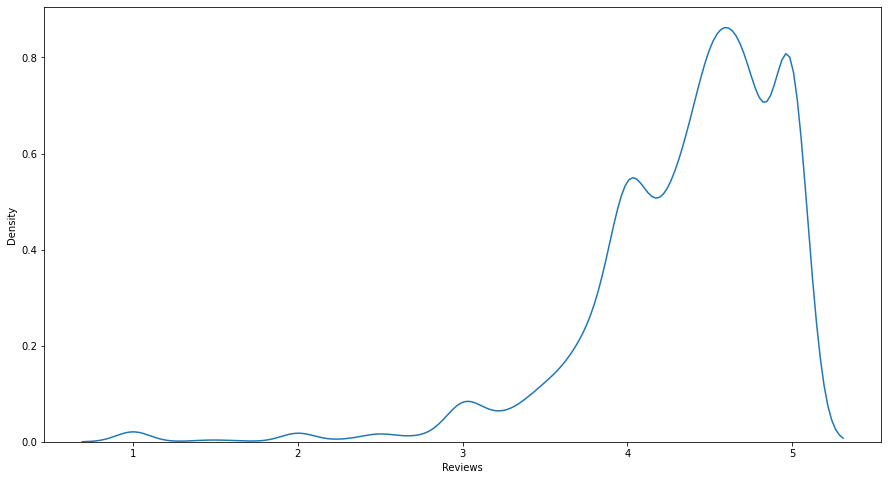

In [32]:
plt.figure(figsize=(15,8))  #Inspect distribution
sns.kdeplot(x= 'Reviews',data = train);

**The distribution is severely left skewed so the missing values should be replaced with the median.**

In [33]:
train['Reviews'].fillna(train['Reviews'].median(),inplace = True)

### Cleaning 'Ratings' column

In [34]:
train['Ratings'] = train['Ratings'].str.extract('(\d+)') #Extract No. of reviews from the column

In [35]:
train['Ratings'] = pd.to_numeric(train['Ratings'], errors='coerce', downcast='integer') #Turn column to suitable datatype

In [36]:
train['Ratings'].isna().sum() #Inspect nan values

47

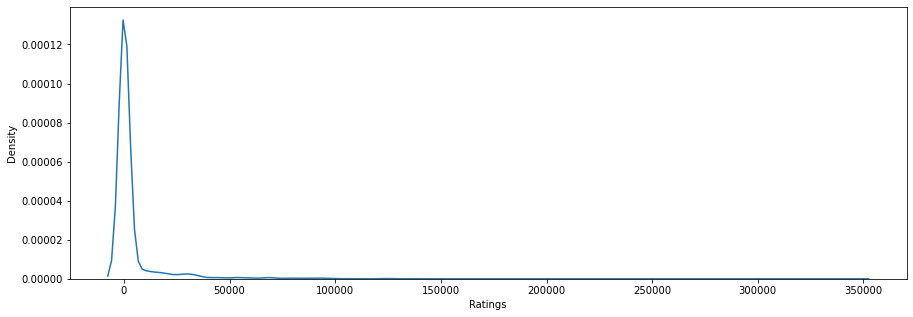

In [37]:
plt.figure(figsize=(15,5)) #Inspect distribution
sns.kdeplot(x= 'Ratings',data = train);

**The distribution is severely right skewed so the missing values should be replaced with the median.**

In [38]:
train['Ratings'].fillna(train['Ratings'].median(),inplace = True)

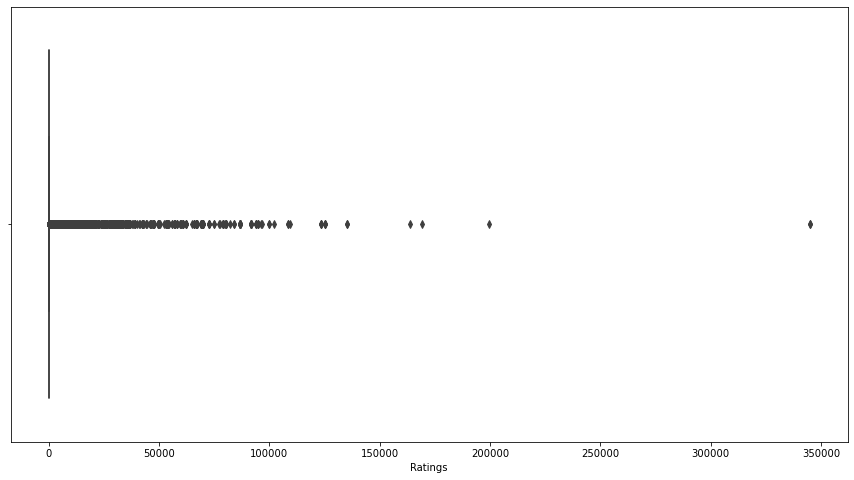

In [39]:
plt.figure(figsize=(15,8)) #Inspect boxplot
sns.boxplot(x='Ratings',data=train);

**The column contains multiple outliers but they can be ignored as some books may be extremely famous therefore have a huge amount of reviews.**

### Cleaning 'Genre' and 'BookCategory' columns

In [40]:
train['Genre'] = train['Genre'].astype('category')
train['Genre'].fillna(train['Genre'][0], inplace=True)
train['Book'] = np.nan

for index, entrie in enumerate(train['Genre']):        #Create Book column with binary encoding of whether the book had
    koro = entrie.split('(')                           #(book) in its Genre or not
    if len(koro) == 1 :
        train.loc[index, 'Book'] = 1 
        
    else:
        train.loc[index, 'Book'] = 0
train['Book'].fillna(train['Book'].mode()[0],inplace = True)

In [41]:
train['Author'].fillna(train['Author'].mode()[0],inplace = True) #Fill nan values with the mode

In [42]:
train['BookCategory'].fillna(train['BookCategory'].mode()[0],inplace = True) #Fill nan values with the mode

In [43]:
train.head() #Inspect data

,Author,Edition,Reviews,Ratings,Genre,BookCategory,Price,Cover,Date,Book
0,0,"Paperback,– Import, 1 Apr 2008",5.0,1.0,Comics & Mangas (Books),Comics & Mangas,2.292,Paperback,2008.0,0.0
1,2,"Paperback,– 27 Mar 2014",4.5,474.0,Action & Adventure (Books),"Crime, Thriller & Mystery",4.800,Paperback,2014.0,0.0
2,1,"Paperback,– 28 May 2000",4.9,15.0,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",10.500,Paperback,2000.0,0.0
3,1,"Paperback,– 24 Sep 2013",4.8,52.0,Biographies & Autobiographies (Books),Sports,5.520,Paperback,2013.0,0.0
4,1,"Paperback,– 28 Jul 2017",4.5,2.0,Romance (Books),Romance,4.776,Paperback,2017.0,0.0


In [44]:
train.drop(train.tail(191).index,inplace=True) #Remove redundant data

### Cleaning 'Price' column

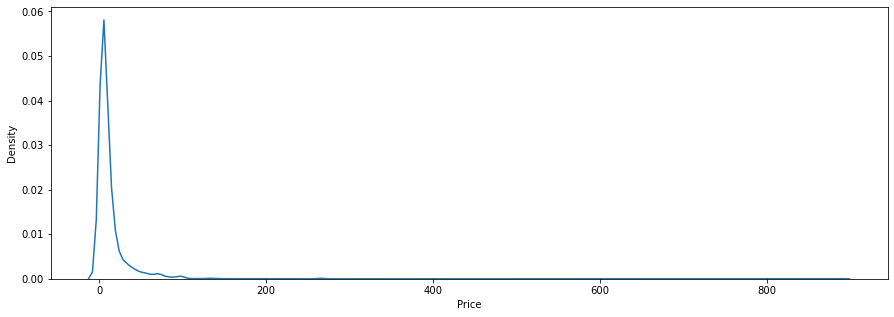

In [45]:
plt.figure(figsize=(15,5)) #Inspect distribution
sns.kdeplot(x= 'Price',data = train);

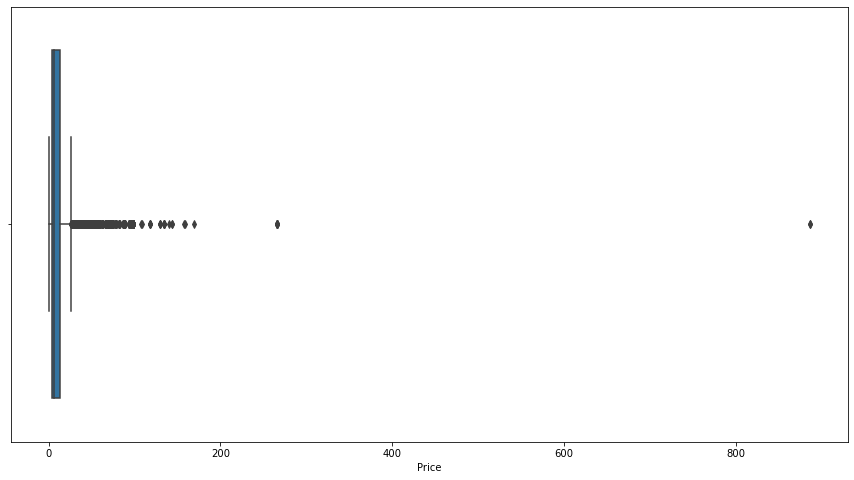

In [46]:
plt.figure(figsize=(15,8)) #Inspect box plot
sns.boxplot(x='Price',data=train);

**Any book more expensive than 200 dollars seems excessive**

In [47]:
train.loc[train['Price'] > 200,'Price'] = None

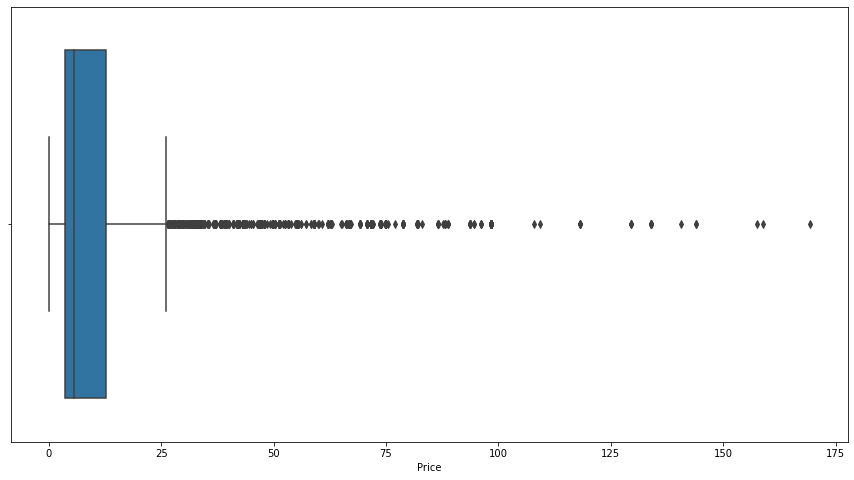

In [48]:
plt.figure(figsize=(15,8)) #Inspect box plot again
sns.boxplot(x='Price',data=train);

In [49]:
train['Price'].fillna(train['Price'].median(),inplace = True) #Fill nan values with the median

## Data Cleaning (Test) 
**(Same steps as in cleaning train set**)

In [50]:
test.drop(['Title','Synopsis'],axis =1,inplace = True)

In [51]:
test.drop_duplicates(inplace = True)
test.drop('ID',axis = 1,inplace = True)

### Cleaning 'Author' column

In [52]:
test['Author'] = test['Author'].astype(str)
test['Genre'] = test['Genre'].astype(str)
test['BookCategory'] = test['BookCategory'].astype(str)

In [53]:
test['Author'] = test['Author'].map(auth_prc)

In [54]:
test['Author'].fillna(train['Author'].mode()[0],inplace =True)

### Splitting 'Edition' column to 'Cover' & 'Date' Columns

In [55]:
years_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov', 'Dec']

for index, entrie in enumerate(test['Edition']):
    koro = entrie.split(',– ')[0].split(',- ')
    if len(koro) == 1:
        if koro[0][0:3] in years_short:
            test.loc[index, 'Cover'] = np.nan
            
        else:
            test.loc[index, 'Cover'] = koro[0]
    else:
        test.loc[index, 'Cover'] = koro[0]

In [56]:
test['Cover'].fillna(train['Cover'].mode()[0],inplace=True)

In [57]:
test['Date'] = np.nan

for index, entrie in enumerate(test['Edition'].str.split('Paperback')):
    test['Date'][index] = entrie[-1].split(",")[-1].split('– ')[-1][-4:]

In [58]:
test['Date'] = pd.to_numeric(test['Date'], errors='coerce', downcast='integer')

test['Date'].fillna(train['Date'].mode()[0],inplace = True)

test['Date'].unique()

test['Date'].isna().sum()

0

In [59]:
train.drop(['Edition'],axis = 1,inplace = True)
test.drop(['Edition'],axis = 1,inplace = True)

### Cleaning 'Reviews' column

In [60]:
test['Reviews']= test['Reviews'].str[:3]

In [61]:
test['Reviews'] = test['Reviews'].astype(float)

In [62]:
test['Reviews'].isna().sum()

14

In [63]:
test['Reviews'].fillna(train['Reviews'].median(),inplace = True)

### Cleaning 'Ratings' column

In [64]:
test['Ratings'] = test['Ratings'].str.extract('(\d+)')

In [65]:
test['Ratings'] = pd.to_numeric(test['Ratings'], errors='coerce', downcast='integer')

In [66]:
test['Ratings'].isna().sum()

14

In [67]:
test['Ratings'].fillna(train['Ratings'].median(),inplace = True)

### Cleaning 'Genre' and 'BookCategory' columns

In [68]:
test['Genre'] = test['Genre'].astype('category')
test['Genre'].fillna(train['Genre'].mode()[0], inplace=True)
test['Book'] = np.nan

for index, entrie in enumerate(test['Genre']):
    koro = entrie.split('(')
    if len(koro) == 1 :
        test.loc[index, 'Book'] = 1
        
    else:
        test.loc[index, 'Book'] = 0

In [69]:
test['Author'].fillna(train['Author'].mode()[0],inplace = True)

In [70]:
test['BookCategory'].fillna(train['BookCategory'].mode()[0],inplace = True)

## Modelling ⚙️

### Encoding

In [71]:
le = LabelEncoder()
columns = ['Genre','BookCategory','Cover'] #Used label encoder for categorical columns

for column in columns:
    train[column] = le.fit_transform(train[column])
    test[column] = le.fit_transform(test[column])

### Cross Validation

In [75]:
X = train.drop('Price',axis = 1)
y = train['Price']

In [76]:
ridge = RidgeCV()                            #Created model variables
lasso = LassoCV()
dt = DecisionTreeRegressor(max_depth = 4)
knn = KNeighborsRegressor(n_neighbors= 9)
rf = RandomForestRegressor(max_depth = 6, n_estimators = 90, random_state = 73)
gbr = GradientBoostingRegressor(max_depth = 3, n_estimators = 50, random_state = 37)
lr = LinearRegression()

In [77]:
metric = 'neg_mean_absolute_error'         #Cross validation

print("RidgeCV score = ", cross_val_score(ridge, X, y, cv=5, scoring = metric).mean()*-1)
print("LassoCV score = ", cross_val_score(lasso, X, y, cv=5, scoring = metric).mean()*-1)
print("DecisionTreeRegressor score = ", cross_val_score(dt, X, y, cv=5, scoring = metric).mean()*-1)
print("KNeighborsRegressor score = ", cross_val_score(knn, X, y, cv=5, scoring = metric).mean()*-1)
print("RandomForestRegressor score = ", cross_val_score(rf, X, y, cv=5, scoring = metric).mean()*-1)
print("GradientBoostingRegressor score = ", cross_val_score(gbr, X, y, cv=5, scoring = metric).mean()*-1)
print("Linear Regression score = ", cross_val_score(lr, X, y, cv=5, scoring = metric).mean()*-1)

RidgeCV score =  8.42095324970043
LassoCV score =  7.975540498549542
DecisionTreeRegressor score =  5.829128476928617
KNeighborsRegressor score =  7.28780412802498
RandomForestRegressor score =  5.232188919975017
GradientBoostingRegressor score =  5.271520931607606
Linear Regression score =  8.433743779031394


**Random Forest performs best**

### Applying Best Algorithm

In [78]:
rf.fit(X,y)
y_pred = rf.predict(test)

In [79]:
pred = pd.DataFrame({'ID':ID,'Price': y_pred})
pred.head()

,ID,Price
0,0,27.306399
1,1,5.396997
2,2,50.863632
3,3,24.471853
4,4,6.122887


In [80]:
pred.to_csv('FinalBookPrediction.csv',index=False)